In [1]:
import sys
sys.path.append('..')

# standard
import json
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from statistics import median
from statistics import mean
from matplotlib import pyplot as plt
from sklearn import metrics
import matplotlib.ticker as ticker
from scipy import stats

# my lib
import PPILinkPred as pred
import genData_helper as helper
import traversalHelper as tr
import bioGRID
import STRING
import MINT

In [2]:
colors = {
    "L3E_f1": "tab:blue",
    "L3E_f2": "tab:olive",
    "L3": "tab:orange",
    "CN": "tab:green",
    "CRA": "tab:red",
    "CH2": "tab:brown",
    "Sim": "tab:purple",
    "rand": "tab:grey"
}

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "random"]+["L3E1_{}".format(i) for i in ['f1', 'f2']]
methods_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand"]+["L3E_{}".format(i) for i in ['f1', 'f2']]
abbrev_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand"]+["L3E\n($f_{"+str(i)+"}$)" for i in range(1,3)]
label_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand"]+["L3E($f_{"+str(i)+"}$)" for i in range(1,3)]

methods_names = dict(zip(methods, methods_map))
abbrevs = dict(zip(methods_map, abbrev_map))
labels = dict(zip(methods_map, label_map))

# generate data

using the script score_realPPIs_HPC.py and score_realNonPPIs_HPC.py in the same directory

# read result data raw & df

In [3]:
dss = ['bioGRID', 'STRING', 'MINT']
methods = ["commonNeighbor", "L3Normalizing", "CRA", "CH2_L3", "Sim"]+["L3E1_{}".format(i) for i in ['f1', 'f2']]

predScores = {}
for ds in dss:
    predScores[ds] = {}
    for method in methods:
        with open("ppiScoring_out/{}_{}_score.json".format(method, ds), 'r') as f:
            predScores[ds][method] = np.asarray(sorted(json.loads(f.read())))

nonPredScores = {}
for ds in dss:
    nonPredScores[ds] = defaultdict(list)
    for method in methods:
        for i in range(10):
                with open("ppiScoring_out/{}_{}_nonPPI_score_{}.json".format(method, ds, i), 'r') as f:
                    nonPredScores[ds][method].append(np.asarray(sorted(json.loads(f.read()))))

In [4]:
nonPredScores_df = defaultdict(list)
for ds in nonPredScores:
    for method in nonPredScores[ds]:
        maxScore = np.max(predScores[ds][method])
        for trial in range(10):
            for i in range(len(nonPredScores[ds][method][trial])):
                nonPredScores_df['ds'].append(ds)
                nonPredScores_df['method'].append(methods_names[method])
                nonPredScores_df['trial'].append(trial)
                nonPredScores_df['score'].append(nonPredScores[ds][method][trial][i])
                nonPredScores_df['normScore'].append(nonPredScores[ds][method][trial][i]/maxScore)
nonPredScores_df = pd.DataFrame(nonPredScores_df)

predScores_df = defaultdict(list)
for ds in predScores:
    for method in predScores[ds]:
        maxScore = np.max(predScores[ds][method])
        for i in range(len(predScores[ds][method])):
            predScores_df['ds'].append(ds)
            predScores_df['method'].append(methods_names[method])
            predScores_df['score'].append(predScores[ds][method][i])
            predScores_df['normScore'].append(predScores[ds][method][i]/maxScore)
predScores_df = pd.DataFrame(predScores_df)

In [18]:
predScores_df[['ds', 'method', 'score']].groupby(['ds', 'method']).describe()

score                                                      \
                   count          mean            std       min          25%   
ds      method                                                                 
MINT    CH2      16927.0    696.186856    1405.534398  2.000000    82.438638   
        CN       16927.0      3.284280       4.911013  0.000000     0.000000   
        CRA      16927.0      0.816778       2.027925  0.000000     0.000000   
        L3       16927.0      5.051580       4.023184  0.540769     2.324465   
        L3E_f1   16927.0     13.973842      24.697683  1.000000     2.272274   
        L3E_f2   16927.0      3.994921       8.010848  1.000000     1.173403   
        Sim      16927.0      9.110569      12.179820  2.000000     3.768877   
STRING  CH2      94529.0  81154.131734  154705.906950  2.000000  1790.682804   
        CN       94529.0     56.490918      62.567246  0.000000     9.000000   
        CRA      94529.0     30.581305      45.408940  0.000000     0.782878   
        L3       94529.0     47.959629      53.970198  0.556296     9.119842   
        L3E_f1   94529.0   2282.453777    4622.504425  1.000000    13.672128   
        L3E_f2   94529.0    850.419542    1769.179902  1.000000     4.293656   
        Sim      94529.0     69.099469      79.620136  2.000000    12.538957   
bioGRID CH2     113116.0  40923.220487   97636.315351  3.218025   864.646605   
        CN      113116.0     15.947850      28.275248  0.000000     4.000000   
        CRA     113116.0      1.724377       7.735135  0.000000     0.024493   
        L3      113116.0     21.184563      28.192667  0.312428     5.136126   
        L3E_f1  113116.0     80.692600     231.331163  1.000020     5.095504   
        L3E_f2  113116.0      8.325250      13.176038  1.000020     1.707962   
        Sim     113116.0     48.847802      67.276897  2.004950     9.703985   

                                                         
                        50%           75%           max  
ds      method                                           
MINT    CH2      225.247501    569.945965  1.347013e+04  
        CN         1.000000      4.000000  2.550000e+02  
        CRA        0.000000      0.437905  3.143175e+01  
        L3         3.625232      6.532628  5.733334e+01  
        L3E_f1     4.369060     11.046281  2.071976e+02  
        L3E_f2     1.522126      2.866094  7.657028e+01  
        Sim        5.499398      9.394277  1.043265e+02  
STRING  CH2     7547.709413  74218.309899  1.287565e+06  
        CN        30.000000     82.000000  3.840000e+02  
        CRA        8.635641     40.520723  2.654337e+02  
        L3        23.158415     65.888183  2.669271e+02  
        L3E_f1    99.839188   1365.429683  2.865706e+04  
        L3E_f2    23.770635    485.320665  7.918057e+03  
        Sim       30.064449     97.205867  2.760999e+02  
bioGRID CH2     3511.229457  21228.482211  1.635595e+06  
        CN         9.000000     19.000000  2.333000e+03  
        CRA        0.245059      1.278954  1.008247e+03  
        L3        11.959398     27.887051  1.274731e+03  
        L3E_f1    17.358756     74.910601  2.273335e+04  
        L3E_f2     3.535520      9.094433  1.734508e+02  
        Sim       21.252668     54.634807  5.118918e+02

## folded changes against all

In [19]:
# lets do the basic thing here, range of predScores vs nonPredScores
# do all trials' diff, mean the diff
predStats = predScores_df.groupby(['ds', 'method']).describe().reset_index()
nonPredStatss = [nonPredScores_df[nonPredScores_df['trial'] == trial].groupby(['ds', 'method', 'trial']).describe().reset_index() for trial in range(10)]
mean_diff, mean_std, samples = {}, {}, {}
methods = ["CN", "L3", "CRA", "CH2", "Sim", "L3E_f1", "L3E_f2"]

for ds in set(predStats['ds']):
    mean_diff[ds], mean_std[ds], samples[ds] = {}, {}, {}
    for method in methods:
        diffs = []
        for trial in range(10):
            diff = float(predStats[(predStats['ds'] == ds) & (predStats['method'] == method)][('score', 'mean')] / nonPredStatss[trial][
                (nonPredStatss[trial]['ds'] == ds) & (nonPredStatss[trial]['method'] == method)][('score', 'mean')])
            diffs.append(diff)
        diff, std = mean(diffs), np.std(diffs)
        mean_diff[ds][method], mean_std[ds][method], samples[ds][method] = diff, std, diffs

mean score


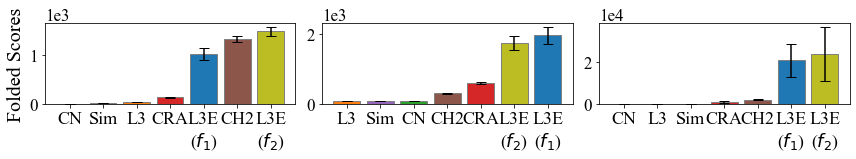

In [26]:
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=17)
plt.rc('legend', fontsize=13)
plt.rcParams["font.family"] = "Times New Roman"

print("mean score")
fig, axes = plt.subplots(1, 3, figsize=(12, 2.3))
for i in range(len(dss)):
    ds = dss[i]
    mean_diff[ds] = dict(sorted(mean_diff[ds].items(), key=lambda item: item[1]))
    xtick = [x for x in list(mean_diff[ds].keys())]
    axes[i].bar([abbrevs[x] for x in xtick]
          , [mean_diff[ds][x] for x in xtick], yerr=[mean_std[ds][x] for x in xtick]
          , capsize=5, edgecolor='grey', color=[colors[x] for x in xtick])
    axes[i].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    #axes[i].set_title("{}) {} Yeast".format(i+1, ds))
    #ttl = axes[i].title
    #ttl.set_position([.5, 1.05])

axes[0].set_ylabel('Folded Scores')
plt.tight_layout()
plt.savefig("./img_experiments/allFolded.png", dpi=300)
plt.show()

In [62]:
# p val
# sample to do: top 2 both to third, between top 2
pairss = [[['L3E_f1', 'L3E_f2'], ['L3E_f2', 'CH2'], ['L3E_f1', 'CH2']]
        , [['L3E_f1', 'L3E_f2'], ['L3E_f2', 'CRA'], ['L3E_f1', 'CRA']]
        , [['L3E_f1', 'L3E_f2'], ['CH2', 'L3E_f1'], ['L3E_f2', 'CH2']]
         ]
dss = ['bioGRID', 'STRING', 'MINT']
for i in range(len(dss)):
    ds = dss[i]
    print(ds)
    for pair in pairss[i]:
        pop1 = samples[ds][pair[0]]
        pop2 = samples[ds][pair[1]]
        pVal = stats.ttest_ind(pop1, pop2)[1]
        print("{} {}: {}".format(pair[0], pair[1], pVal))

bioGRID
L3E1_f1 L3E1_f2: 3.935478657807837e-08
L3E1_f2 CH2: 0.0005365484211180643
L3E1_f1 CH2: 1.8465145723048475e-06
STRING
L3E1_f1 L3E1_f2: 0.05039037080106344
L3E1_f2 CRA: 1.5200539715433324e-12
L3E1_f1 CRA: 2.0579512569447165e-12
MINT
L3E1_f1 L3E1_f2: 0.5339319853211415
CH2 L3E1_f1: 8.836080517088367e-07
L3E1_f2 CH2: 7.284913481187444e-05
